# Notebook: Create Wordcloud Analysis 

This notebook is used to create wordclouds using our trained model.
<br>**Contributors:** [Nils Hellwig](https://github.com/NilsHellwig/) | [Markus Bink](https://github.com/MarkusBink/)

## Packages

In [1]:
from reportlab.graphics import renderPDF
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from svglib.svglib import svg2rlg
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import nltk
import re

## Parameters

In [2]:
PLOTS_PATH = "../Plots/"

## Setup Packags

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("german"))
STOPWORDS.update(["mehr", "heute","https", "bundestag", "thread", "anzeigen"])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nils_hellwig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nils_hellwig/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Code

### 1. Load Data

In [6]:
df = pd.read_csv("all_tweets_predicted_bert93.csv")[["Embedded_text", "sentiment_prediction"]]
df = df.rename(columns={'Embedded_text': 'text', 'sentiment_prediction': 'sentiment'})

In [7]:
df

,text,sentiment
0,AfD wirkt.\n\nSchluss mit dem #Gendergaga\nMDR...,2
1,Im Herbst wird gewählt.\nSchluss mit den Recht...,2
2,Behördenwillkür\nFlüchtlingsheime durchgedrück...,1
3,Aus Raider wird jetzt Twix \n\nLeider kein #Ap...,2
4,Gendern geht („*innen“)\nImpfen geht nicht.\nD...,1
...,...,...
58859,Friedlicher Protest gegen einen #Impfzwang ist...,1
58860,@OlafScholz\n muss sich endlich klar zu Nord S...,0
58861,Mit \n@_FriedrichMerz\n gibt es keine konserva...,1
58862,Wir wünschen Ihnen und Ihrer Familie einen bes...,0


### 2. Function to Clean Text
Source: https://data-dive.com/german-nlp-binary-text-classification-of-reviews-part1

In [8]:
def clean_text(text):
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    
    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)
    
    word_tokens = word_tokenize(text)
    text = [word.lower() for word in word_tokens]
    text = " ".join(text)
    
    return text

### 3. SVG to PDF

In [9]:
def svg_to_pdf(svg_filepath, pdf_filepath):
    drawing = svg2rlg(svg_filepath)
    renderPDF.drawToFile(drawing, pdf_filepath)

### 4. Create Wordclouds for Positive, Negative and Neutral Tweets

Word Cloud for Sentiment: 0


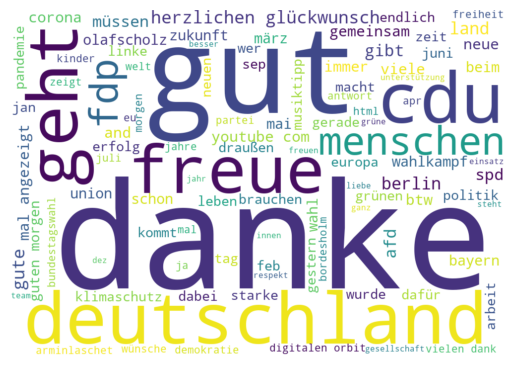

Word Cloud for Sentiment: 1


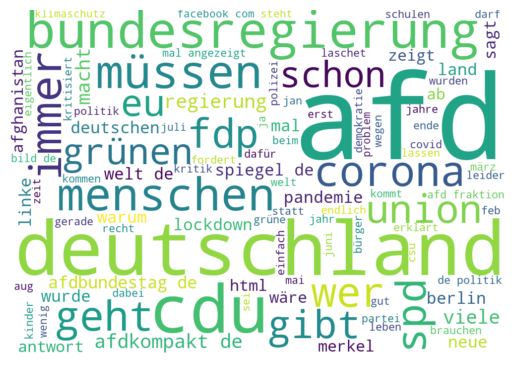

Word Cloud for Sentiment: 2


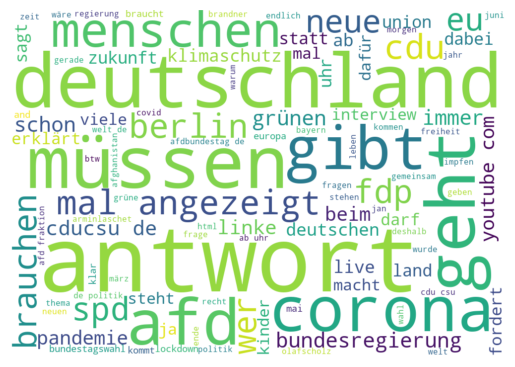

In [10]:
# Group dataframe by sentiment
grouped = df.groupby('sentiment')

# Iterate over each group
for sentiment, group in grouped:
    print(f'Word Cloud for Sentiment: {sentiment}')
    
    # Create a list of all the tweets for the current sentiment
    tweets = group['text'].tolist()
    
    # Create a single string of all the tweets for the current sentiment
    text = ' '.join(tweets)
    
    # Clean Text
    text = clean_text(text)
    
    # Create a wordcloud
    wordcloud = WordCloud(background_color="white", max_words=100, width=1000, height=700, stopwords=STOPWORDS).generate(text)
    
    # Save wordcloud as svg
    wordcloud_svg = wordcloud.to_svg(embed_font=True)
    svg_path = PLOTS_PATH + "wordcloud_" + str(sentiment) + ".svg"
    f = open(svg_path, "w+")
    f.write(wordcloud_svg)
    f.close()
    
    # Save wordcloud as pdf
    pdf_path = PLOTS_PATH + "wordcloud_" + str(sentiment) + ".pdf"
    svg_to_pdf(svg_path, pdf_path)
    
    # Save wordcloud as png
    png_path = PLOTS_PATH + "wordcloud_" + str(sentiment) + ".png"
    wordcloud.to_file(png_path)
    
    # Display the wordcloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()